In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from pmdarima import auto_arima


In [23]:
df=pd.read_csv('C:/Users/wasan/Documents/Final Edition/Weather Data Set/Univariate/Kiriwaneliya_project.csv')
df.head()




,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max
0,2010,January,104.699999,11.0,20.2,NaN,NaN
1,2010,February,34.600000,12.0,22.1,NaN,NaN
2,2010,March,128.300001,11.5,23.0,NaN,NaN
3,2010,April,153.200000,13.1,22.5,NaN,NaN
4,2010,May,174.300002,14.1,21.7,NaN,NaN


In [24]:
df["Time"]=df["Year"].astype(str)+"-"+df["Month"].astype(str)


In [25]:
df.head()

,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max,Time
0,2010,January,104.699999,11.0,20.2,NaN,NaN,2010-January
1,2010,February,34.600000,12.0,22.1,NaN,NaN,2010-February
2,2010,March,128.300001,11.5,23.0,NaN,NaN,2010-March
3,2010,April,153.200000,13.1,22.5,NaN,NaN,2010-April
4,2010,May,174.300002,14.1,21.7,NaN,NaN,2010-May


In [26]:
#Slicing dataset
temperature_max=df[["Time","Temp_max"]]
temperature_max.head()

,Time,Temp_max
0,2010-January,20.2
1,2010-February,22.1
2,2010-March,23.0
3,2010-April,22.5
4,2010-May,21.7


In [27]:
temperature_max['Time']=pd.to_datetime(temperature_max['Time'])

C:\Users\wasan\AppData\Local\Temp/ipykernel_420/653730226.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature_max['Time']=pd.to_datetime(temperature_max['Time'])


In [28]:
temperature_max.head()

,Time,Temp_max
0,2010-01-01,20.2
1,2010-02-01,22.1
2,2010-03-01,23.0
3,2010-04-01,22.5
4,2010-05-01,21.7


In [29]:
#Checking for missing values
temperature_max.isna().sum()

Time        0
Temp_max    1
dtype: int64

In [30]:
#removing missing values
temp=temperature_max.dropna(how="any")
temp.head()

,Time,Temp_max
0,2010-01-01,20.2
1,2010-02-01,22.1
2,2010-03-01,23.0
3,2010-04-01,22.5
4,2010-05-01,21.7


In [31]:
#Rename column
temp = temp.rename(columns = {'Temp_max': 'Temperature Max'}, inplace = False)
temp.head()

,Time,Temperature Max
0,2010-01-01,20.2
1,2010-02-01,22.1
2,2010-03-01,23.0
3,2010-04-01,22.5
4,2010-05-01,21.7


In [32]:
#Checking for missing values
temp.isna().sum()

Time               0
Temperature Max    0
dtype: int64

In [33]:
temp.set_index('Time',inplace=True)

<AxesSubplot:xlabel='Time'>

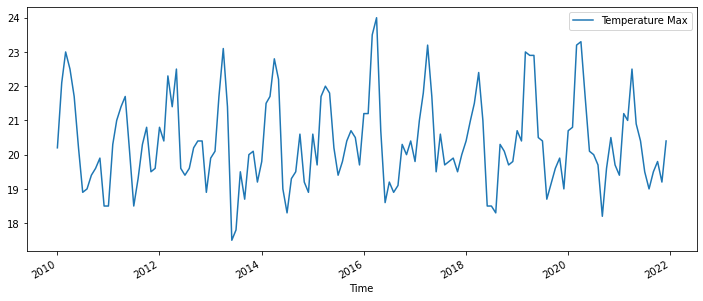

In [37]:
temp.plot(figsize=(12,5))

It can't be cleary identified trend or seasonality.

In [38]:
### ADF Test
test_result=adfuller(temp['Temperature Max'])
#Ho: The series is non stationary
#H1: The series is stationary

def adfuller_test(rainfall):
    result=adfuller(rainfall)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(temp['Temperature Max'])

ADF Test Statistic : -3.0809145041181187
p-value : 0.02799822161576664
#Lags Used : 13
Number of Observations Used : 129
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [39]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(temp['Temperature Max'])

KPSS Statistic: 0.0752249215026813
p-value: 0.1
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [40]:
#PhillipsPerron Test
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(temp['Temperature Max'].astype(float))
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -5.027
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# ACF and PACF plots

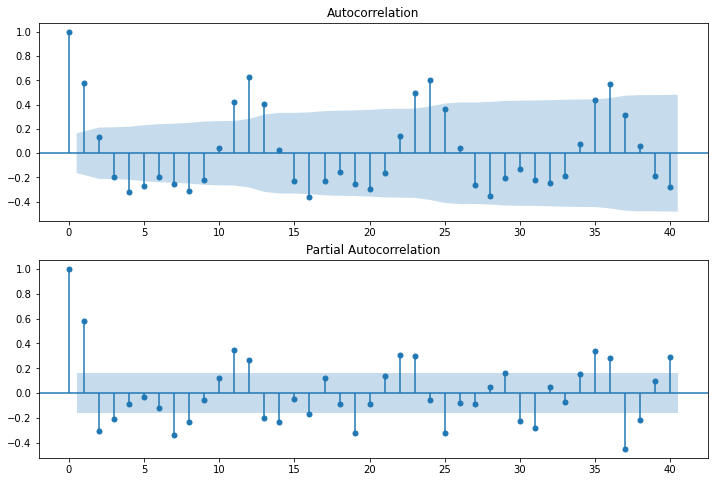

In [41]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(temp['Temperature Max'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(temp['Temperature Max'],lags=40,ax=ax2)

In [42]:

#According to PACF and ACF plots,better to start with p=2 d=0 and q=1 can be considered.
arima_model=auto_arima(temp['Temperature Max'].astype(float),start_p=0,start_q=0,max_p=3,max_q=1,start_P=0,start_D=0,start_Q=0,max_P=3,max_D=1,max_Q=1,m=12,seasonal=True,error_action='warn',trace=True,supress_warnings=True,stepwise=True,random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=486.698, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=394.617, Time=0.73 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=407.244, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1270.495, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=431.180, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=365.276, Time=0.88 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=inf, Time=2.65 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=359.978, Time=1.31 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=368.029, Time=2.68 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=384.601, Time=1.27 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=371.090, Time=1.44 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(2,0,1)(2,0,1)[12] intercept   : AIC=383.7

# Forecast using the model

In [43]:
model=sm.tsa.statespace.SARIMAX(temp['Temperature Max'].astype('float'),order=(1, 0, 0),seasonal_order=(2,0,1,12))
results=model.fit()
results.summary()

C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      Temperature Max   No. Observations:                  143
Model:             SARIMAX(1, 0, 0)x(2, 0, [1], 12)   Log Likelihood                -201.780
Date:                              Wed, 06 Apr 2022   AIC                            413.561
Time:                                      12:46:45   BIC                            428.375
Sample:                                           0   HQIC                           419.581
                                              - 143                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9829      0.018     55.955      0.000       0.948       1.017
ar.S.L12       1.0074      0.201      5.018      0.000       0.614       1.401
ar.S.L24      -0.0454      0.171     -0.266      0.790      -0.380       0.289
ma.S.L12      -0.7386      0.176     -4.191      0.000      -1.084      -0.393
sigma2         0.8842      0.112      7.871      0.000       0.664       1.104
===================================================================================
Ljung-Box (L1) (Q):                  13.35   Jarque-Bera (JB):                 1.35
Prob(Q):                              0.00   Prob(JB):                         0.51
Heteroskedasticity (H):               1.04   Skew:                            -0.24
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Time'>

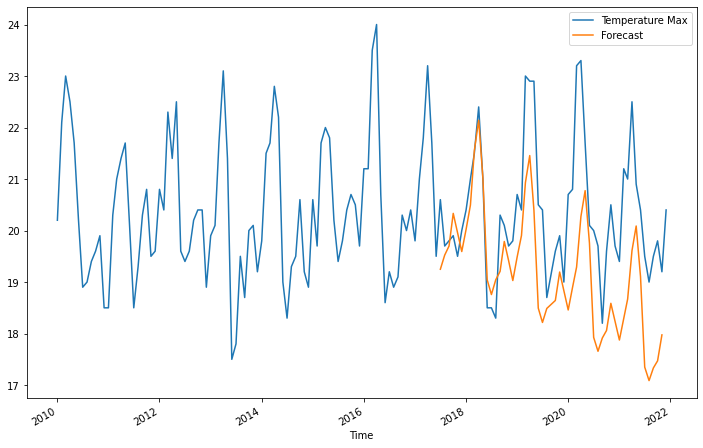

In [44]:
temp['Forecast']=results.predict(start=90,end=141,dynamic=True)
temp[['Temperature Max','Forecast']].plot(figsize=(12,8))

In [45]:
temp.tail()


,Temperature Max,Forecast
Time,,
2021-08-01,19.0,17.087390
2021-09-01,19.5,17.333136
2021-10-01,19.8,17.470516
2021-11-01,19.2,17.974579
2021-12-01,20.4,NaN
